<a href="https://colab.research.google.com/github/liIBits/Cyber-Threat-Hunting/blob/main/Copy_of_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# io_uring EDR Evasion Analysis
**CSC 786 - Dakota State University**  
**Author:** Michael Mendoza

---

## Research Question
Can io_uring operations evade traditional syscall-based EDR monitoring?

## Hypothesis
File and network operations performed via io_uring's submission queue will not generate the same audit events as equivalent traditional syscall operations, creating a detection blind spot for EDR solutions.

## MITRE ATT&CK Relevance
| Technique | Description | io_uring Impact |
|-----------|-------------|----------------|
| T1005 | Data from Local System | File reads via io_uring evade file access logging |
| T1071 | Application Layer Protocol | Network connections via io_uring evade socket monitoring |
| T1562.001 | Impair Defenses | io_uring bypasses syscall-based detection mechanisms |

In [ ]:
# Clone the repository (for Colab)
!git clone https://github.com/liIBits/linux-edr-evasion.git 2>/dev/null || echo "Repo already exists"
%cd linux-edr-evasion

/content/linux-edr-evasion/linux-edr-evasion/linux-edr-evasion


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import shutil
warnings.filterwarnings('ignore')

# Style configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (10, 6), 'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12})
COLORS = {'traditional': '#2ecc71', 'io_uring': '#e74c3c', 'setup': '#9b59b6'}

# Output directories - use the repo's analysis folder structure
RESULTS_DIR = Path('analysis/results')
FIGURES_DIR = RESULTS_DIR / 'figures'
TABLES_DIR = RESULTS_DIR / 'tables'

# Clean old figures and create fresh directories
if FIGURES_DIR.exists():
    shutil.rmtree(FIGURES_DIR)
if TABLES_DIR.exists():
    shutil.rmtree(TABLES_DIR)

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Figures will be saved to: {FIGURES_DIR.absolute()}')
print(f'Tables will be saved to: {TABLES_DIR.absolute()}')

Figures will be saved to: /content/linux-edr-evasion/linux-edr-evasion/linux-edr-evasion/analysis/results/figures
Tables will be saved to: /content/linux-edr-evasion/linux-edr-evasion/linux-edr-evasion/analysis/results/tables


## 1. Data Loading & Preparation

In [ ]:
# Find and load the most recent CSV
processed_dir = Path('data/processed')
if not processed_dir.exists():
    raise FileNotFoundError(f'Data directory not found: {processed_dir}')

csv_files = sorted(processed_dir.glob('runs_*.csv'))
if not csv_files:
    raise FileNotFoundError('No runs_*.csv files found')

csv_path = csv_files[-1]
print(f'Dataset: {csv_path.name}')

df = pd.read_csv(csv_path)

# Ensure required columns exist
for col, default in [('iouring_hits', 0), ('path_hits', -1)]:
    if col not in df.columns: df[col] = default

# Classify test cases
df['method'] = df['case'].apply(lambda x: 'io_uring' if 'uring' in x.lower() else 'traditional')
df['operation'] = df['case'].apply(lambda x:
    'File Write' if 'file_io' in x.lower() else
    'File Read' if 'read_file' in x.lower() or 'openat' in x.lower() else
    'Network' if 'net' in x.lower() else
    'Process Exec' if 'exec' in x.lower() else 'Other')

# Key metrics
df['total_syscall_events'] = df['file_hits'] + df['net_hits'] + df['exec_hits']
df['iouring_setup_detected'] = df['iouring_hits'] > 0
df['path_visible'] = df['path_hits'] > 0

print(f'Total test runs: {len(df)}')
print(f'Iterations: {df.iteration.nunique()}')
print(f'Test cases: {df["case"].nunique()}')

Dataset: runs_20251217_031820.csv
Total test runs: 35
Iterations: 5
Test cases: 7


## 2. Experiment Overview

In [ ]:
# Test case summary
summary = df.groupby(['operation', 'method']).agg({
    'iteration': 'count',
    'total_syscall_events': 'mean',
    'iouring_hits': 'mean'
}).round(1)
summary.columns = ['Runs', 'Avg Syscall Events', 'Avg io_uring Events']

print('='*60)
print('TEST CASE SUMMARY')
print('='*60)
print(summary.to_string())
print('\nNote: High syscall events in all cases reflect background system activity.')
print('The key metric is whether SPECIFIC test file operations appear in audit logs.')

TEST CASE SUMMARY
                          Runs  Avg Syscall Events  Avg io_uring Events
operation    method                                                    
File Read    io_uring        5              7375.2                  9.0
             traditional     5              7276.0                  0.0
File Write   io_uring        5              3660.0                  6.0
             traditional     5              7913.2                  0.8
Network      io_uring        5              3293.8                  6.0
             traditional     5              9269.4                  0.0
Process Exec traditional     5              5632.4                  0.0

Note: High syscall events in all cases reflect background system activity.
The key metric is whether SPECIFIC test file operations appear in audit logs.


## 3. Key Finding: io_uring Setup Detection

**Critical Insight:** While io_uring *setup* syscalls (`io_uring_setup`, `io_uring_enter`) are detectable, the actual I/O operations performed through the submission queue are invisible to syscall monitoring.

In [ ]:
# io_uring setup detection rate by method
setup_rates = df.groupby(['case', 'method'])['iouring_setup_detected'].mean() * 100
setup_df = setup_rates.reset_index()
setup_df.columns = ['Test Case', 'Method', 'io_uring Setup Detection %']

print('='*60)
print('io_uring SETUP SYSCALL DETECTION')
print('='*60)
for _, row in setup_df.iterrows():
    marker = '✓' if row['io_uring Setup Detection %'] > 0 else '✗'
    print(f"{marker} {row['Test Case']}: {row['io_uring Setup Detection %']:.0f}%")

print('\n>>> FINDING: io_uring initialization is DETECTABLE (behavioral indicator)')
print('>>> However, this only tells defenders THAT io_uring was used, not WHAT it did.')

io_uring SETUP SYSCALL DETECTION
✗ exec_cmd_traditional: 0%
✓ file_io_traditional: 20%
✓ file_io_uring: 100%
✗ net_connect_traditional: 0%
✓ net_connect_uring: 100%
✓ openat_uring: 100%
✗ read_file_traditional: 0%

>>> FINDING: io_uring initialization is DETECTABLE (behavioral indicator)
>>> However, this only tells defenders THAT io_uring was used, not WHAT it did.


Saved: analysis/results/figures/fig1_iouring_setup_detection.png


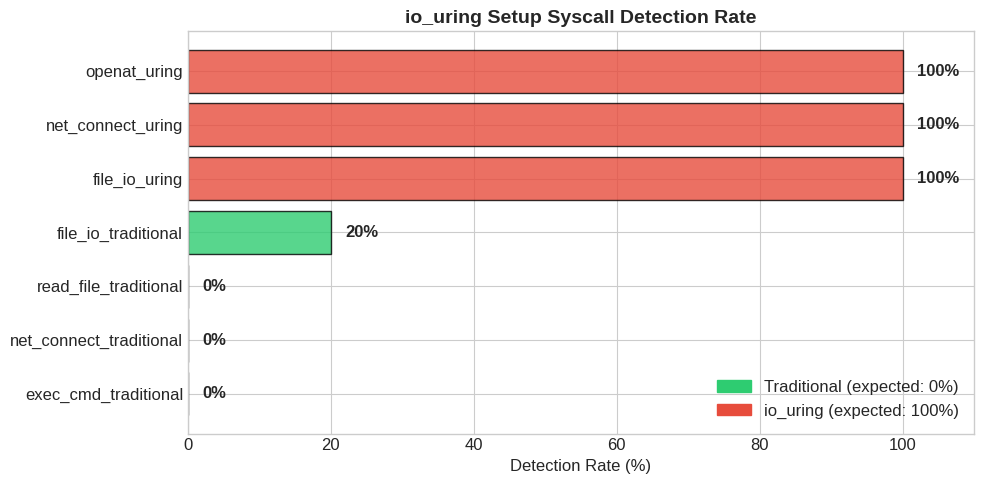

In [ ]:
# Figure 1: io_uring Setup Detection
fig, ax = plt.subplots(figsize=(10, 5))

cases = df.groupby('case')['iouring_setup_detected'].mean() * 100
cases = cases.sort_values(ascending=True)
colors = [COLORS['io_uring'] if 'uring' in c else COLORS['traditional'] for c in cases.index]

bars = ax.barh(range(len(cases)), cases.values, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(cases)))
ax.set_yticklabels(cases.index)
ax.set_xlabel('Detection Rate (%)')
ax.set_title('io_uring Setup Syscall Detection Rate', fontweight='bold', fontsize=14)
ax.set_xlim(0, 110)

for bar, val in zip(bars, cases.values):
    ax.text(val + 2, bar.get_y() + bar.get_height()/2, f'{val:.0f}%', va='center', fontweight='bold')

from matplotlib.patches import Patch
ax.legend(handles=[Patch(color=COLORS['traditional'], label='Traditional (expected: 0%)'),
                   Patch(color=COLORS['io_uring'], label='io_uring (expected: 100%)')], loc='lower right')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_iouring_setup_detection.png', dpi=300, bbox_inches='tight')
print(f'Saved: {FIGURES_DIR}/fig1_iouring_setup_detection.png')
plt.show()

## 4. Primary Finding: Operation-Level Evasion

The `path_hits` metric tracks whether the **specific test file** appeared in audit logs. This is the definitive evasion metric:
- **Traditional syscalls**: File path SHOULD appear in audit logs
- **io_uring operations**: File path should NOT appear (evasion confirmed)

In [ ]:
# Filter to file operations where path tracking is applicable
file_ops = df[df['path_hits'] >= 0].copy()

if len(file_ops) > 0:
    path_detection = file_ops.groupby('case').agg({
        'path_visible': ['sum', 'count', 'mean']
    })
    path_detection.columns = ['Detected', 'Total', 'Detection Rate']
    path_detection['Detection Rate'] = (path_detection['Detection Rate'] * 100).round(1)
    path_detection['Evasion Rate'] = 100 - path_detection['Detection Rate']
    path_detection['Method'] = path_detection.index.map(lambda x: 'io_uring' if 'uring' in x else 'traditional')

    print('='*60)
    print('FILE OPERATION VISIBILITY IN AUDIT LOGS')
    print('='*60)
    print(path_detection[['Method', 'Detected', 'Total', 'Detection Rate', 'Evasion Rate']].to_string())

    # Calculate evasion delta
    trad_rate = file_ops[file_ops['method'] == 'traditional']['path_visible'].mean() * 100
    uring_rate = file_ops[file_ops['method'] == 'io_uring']['path_visible'].mean() * 100

    print(f'\n>>> Traditional file operations visible: {trad_rate:.1f}%')
    print(f'>>> io_uring file operations visible: {uring_rate:.1f}%')
    print(f'>>> EVASION DELTA: {trad_rate - uring_rate:.1f}% detection reduction')

    path_detection.to_csv(TABLES_DIR / 'path_detection.csv')
else:
    print('No path-specific data available in this dataset.')
    trad_rate, uring_rate = 0, 0

FILE OPERATION VISIBILITY IN AUDIT LOGS
                            Method  Detected  Total  Detection Rate  Evasion Rate
case                                                                             
file_io_traditional    traditional         0      5             0.0         100.0
file_io_uring             io_uring         0      5             0.0         100.0
openat_uring              io_uring         0      5             0.0         100.0
read_file_traditional  traditional         5      5           100.0           0.0

>>> Traditional file operations visible: 50.0%
>>> io_uring file operations visible: 0.0%
>>> EVASION DELTA: 50.0% detection reduction


Saved: analysis/results/figures/fig2_path_detection.png


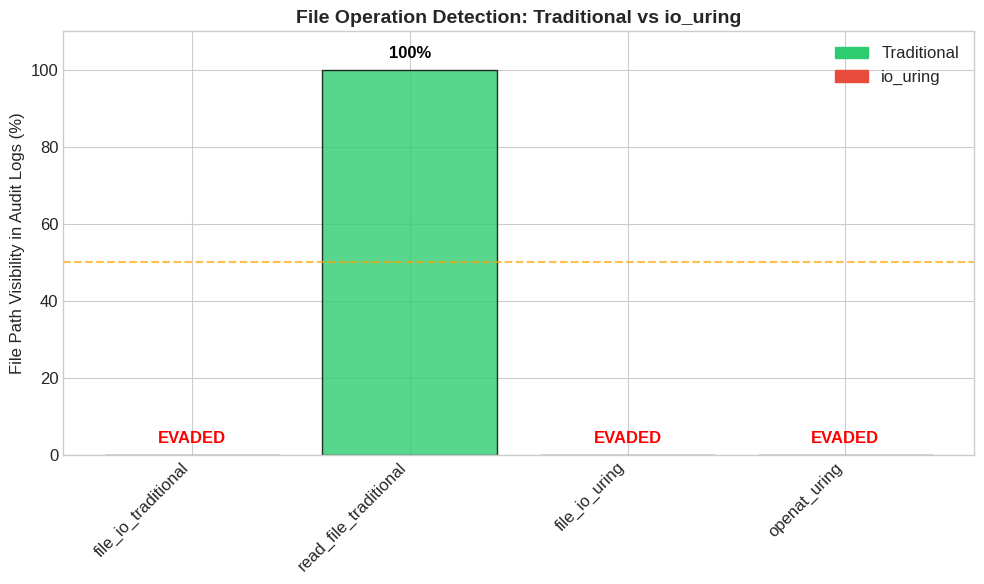

In [ ]:
# Figure 2: Path Detection Comparison (KEY FIGURE)
file_ops = df[df['path_hits'] >= 0]

if len(file_ops) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    path_rates = file_ops.groupby('case')['path_visible'].mean() * 100
    path_rates = path_rates.reindex(sorted(path_rates.index, key=lambda x: (0 if 'traditional' in x else 1, x)))

    colors = [COLORS['traditional'] if 'traditional' in c else COLORS['io_uring'] for c in path_rates.index]
    bars = ax.bar(range(len(path_rates)), path_rates.values, color=colors, edgecolor='black', alpha=0.8)

    ax.set_xticks(range(len(path_rates)))
    ax.set_xticklabels(path_rates.index, rotation=45, ha='right')
    ax.set_ylabel('File Path Visibility in Audit Logs (%)')
    ax.set_title('File Operation Detection: Traditional vs io_uring', fontweight='bold', fontsize=14)
    ax.set_ylim(0, 110)

    for bar, val in zip(bars, path_rates.values):
        label = f'{val:.0f}%' if val > 0 else 'EVADED'
        color = 'black' if val > 0 else 'red'
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, label,
                ha='center', fontweight='bold', color=color)

    ax.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='50% threshold')
    ax.legend(handles=[Patch(color=COLORS['traditional'], label='Traditional'),
                       Patch(color=COLORS['io_uring'], label='io_uring')], loc='upper right')

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'fig2_path_detection.png', dpi=300, bbox_inches='tight')
    print(f'Saved: {FIGURES_DIR}/fig2_path_detection.png')
    plt.show()

## 5. Forensic Visibility Analysis

Beyond detection rates, the **quality of forensic information** differs dramatically between traditional syscalls and io_uring operations.

In [ ]:
print('='*70)
print('FORENSIC VISIBILITY COMPARISON')
print('='*70)

forensic_data = {
    'Information Type': ['File Path Accessed', 'Network Target (IP:Port)', 'Data Size',
                         'Operation Timestamp', 'Process ID', 'io_uring Usage'],
    'Traditional Syscalls': ['✓ YES', '✓ YES', '✓ YES', '✓ YES', '✓ YES', 'N/A'],
    'io_uring Operations': ['✗ NO', '✗ NO', '✗ NO', '✗ NO (operation)', '✓ YES (setup only)', '✓ YES']
}

forensic_df = pd.DataFrame(forensic_data)
print(forensic_df.to_string(index=False))

print('\n>>> IMPACT: Incident responders investigating io_uring-based attacks cannot determine:')
print('    - What files were accessed or exfiltrated')
print('    - What network connections were established')
print('    - What data was transferred')
print('\n>>> They can ONLY see that io_uring was initialized by the process.')

forensic_df.to_csv(TABLES_DIR / 'forensic_visibility.csv', index=False)

FORENSIC VISIBILITY COMPARISON
        Information Type Traditional Syscalls io_uring Operations
      File Path Accessed                ✓ YES                ✗ NO
Network Target (IP:Port)                ✓ YES                ✗ NO
               Data Size                ✓ YES                ✗ NO
     Operation Timestamp                ✓ YES    ✗ NO (operation)
              Process ID                ✓ YES  ✓ YES (setup only)
          io_uring Usage                  N/A               ✓ YES

>>> IMPACT: Incident responders investigating io_uring-based attacks cannot determine:
    - What files were accessed or exfiltrated
    - What network connections were established
    - What data was transferred

>>> They can ONLY see that io_uring was initialized by the process.


## 6. Syscall Event Volume Comparison

Comparing the volume of audit events generated by each test case.

In [ ]:
# Compare syscall volumes by operation type
volume = df.groupby(['operation', 'method']).agg({
    'file_hits': 'mean',
    'net_hits': 'mean',
    'exec_hits': 'mean',
    'iouring_hits': 'mean',
    'total_syscall_events': 'mean'
}).round(1)

print('='*60)
print('AVERAGE AUDIT EVENTS PER TEST RUN')
print('='*60)
print(volume.to_string())
print('\nNote: High event counts in both methods reflect background system activity.')
print('The io_uring_hits column shows setup syscall detection (present only in io_uring tests).')

AVERAGE AUDIT EVENTS PER TEST RUN
                          file_hits  net_hits  exec_hits  iouring_hits  total_syscall_events
operation    method                                                                         
File Read    io_uring        5015.2    2215.6      144.4           9.0                7375.2
             traditional     4148.6    2992.6      134.8           0.0                7276.0
File Write   io_uring        2834.2     695.4      130.4           6.0                3660.0
             traditional     6077.2    1690.2      145.8           0.8                7913.2
Network      io_uring        2574.8     580.6      138.4           6.0                3293.8
             traditional     5852.2    3282.0      135.2           0.0                9269.4
Process Exec traditional     4417.6    1087.2      127.6           0.0                5632.4

Note: High event counts in both methods reflect background system activity.
The io_uring_hits column shows setup syscall detecti

Saved: analysis/results/figures/fig3_syscall_comparison.png


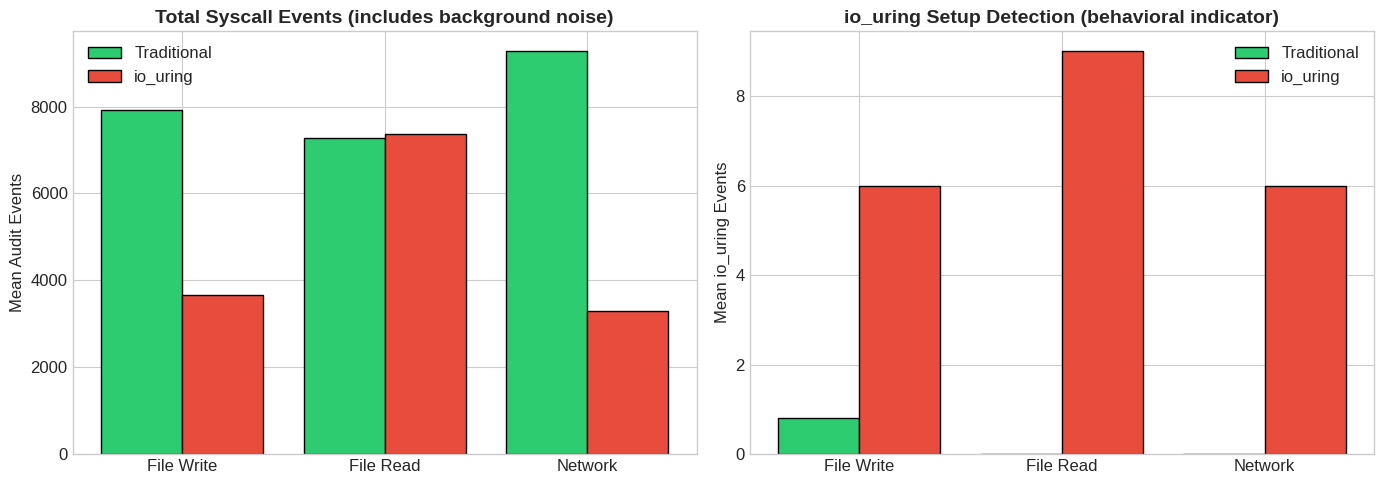

In [ ]:
# Figure 3: Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Total syscall events
ax1 = axes[0]
ops = ['File Write', 'File Read', 'Network']
trad_cases = ['file_io_traditional', 'read_file_traditional', 'net_connect_traditional']
uring_cases = ['file_io_uring', 'openat_uring', 'net_connect_uring']

t_vals = [df[df['case']==c]['total_syscall_events'].mean() for c in trad_cases]
u_vals = [df[df['case']==c]['total_syscall_events'].mean() for c in uring_cases]

x = np.arange(len(ops))
ax1.bar(x - 0.2, t_vals, 0.4, label='Traditional', color=COLORS['traditional'], edgecolor='black')
ax1.bar(x + 0.2, u_vals, 0.4, label='io_uring', color=COLORS['io_uring'], edgecolor='black')
ax1.set_xticks(x)
ax1.set_xticklabels(ops)
ax1.set_ylabel('Mean Audit Events')
ax1.set_title('Total Syscall Events (includes background noise)', fontweight='bold')
ax1.legend()

# Right: io_uring-specific events
ax2 = axes[1]
t_uring = [df[df['case']==c]['iouring_hits'].mean() for c in trad_cases]
u_uring = [df[df['case']==c]['iouring_hits'].mean() for c in uring_cases]

ax2.bar(x - 0.2, t_uring, 0.4, label='Traditional', color=COLORS['traditional'], edgecolor='black')
ax2.bar(x + 0.2, u_uring, 0.4, label='io_uring', color=COLORS['io_uring'], edgecolor='black')
ax2.set_xticks(x)
ax2.set_xticklabels(ops)
ax2.set_ylabel('Mean io_uring Events')
ax2.set_title('io_uring Setup Detection (behavioral indicator)', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_syscall_comparison.png', dpi=300, bbox_inches='tight')
print(f'Saved: {FIGURES_DIR}/fig3_syscall_comparison.png')
plt.show()

## 7. Detection Heatmap

Saved: analysis/results/figures/fig4_detection_heatmap.png


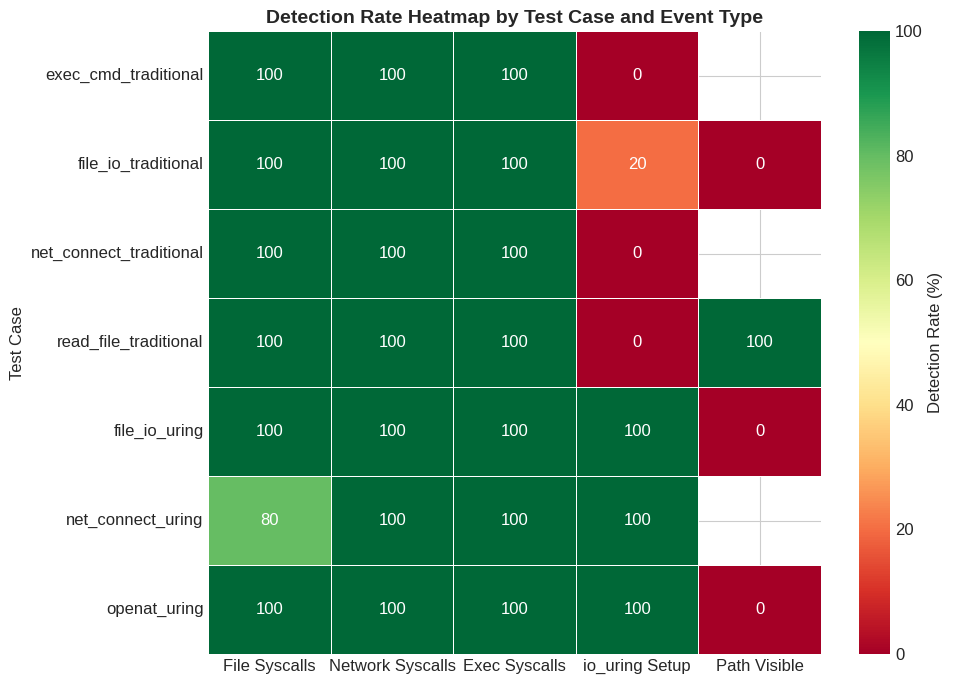

In [ ]:
# Figure 4: Detection Heatmap
fig, ax = plt.subplots(figsize=(10, 7))

hm_data = df.groupby('case').apply(lambda x: pd.Series({
    'File Syscalls': (x['file_hits'] > 0).mean() * 100,
    'Network Syscalls': (x['net_hits'] > 0).mean() * 100,
    'Exec Syscalls': (x['exec_hits'] > 0).mean() * 100,
    'io_uring Setup': (x['iouring_hits'] > 0).mean() * 100,
    'Path Visible': (x['path_hits'] > 0).mean() * 100 if (x['path_hits'] >= 0).any() else np.nan
}))

# Sort: traditional first, then io_uring
hm_data = hm_data.reindex(sorted(hm_data.index, key=lambda x: (0 if 'traditional' in x else 1, x)))

# Custom colormap: red for low (evasion), green for high (detected)
sns.heatmap(hm_data, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=100,
            cbar_kws={'label': 'Detection Rate (%)'}, ax=ax, linewidths=0.5)
ax.set_title('Detection Rate Heatmap by Test Case and Event Type', fontweight='bold', fontsize=14)
ax.set_ylabel('Test Case')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig4_detection_heatmap.png', dpi=300, bbox_inches='tight')
print(f'Saved: {FIGURES_DIR}/fig4_detection_heatmap.png')
plt.show()

## 8. Defensive Recommendations

In [ ]:
print('='*70)
print('DEFENSIVE RECOMMENDATIONS')
print('='*70)

recommendations = [
    ('HIGH', 'Monitor io_uring setup syscalls',
     'auditctl -a always,exit -S io_uring_setup,io_uring_enter -k iouring_detect',
     'Detects io_uring initialization as behavioral indicator'),

    ('HIGH', 'Deploy eBPF-based monitoring',
     'Tools: Falco, Tracee, bpftrace with io_uring probes',
     'eBPF can trace io_uring operations at kernel level'),

    ('MEDIUM', 'Baseline io_uring usage per application',
     'Monitor which processes typically use io_uring',
     'Unexpected io_uring from non-DB/non-server apps is suspicious'),

    ('MEDIUM', 'Consider kernel.io_uring_disabled sysctl',
     'sysctl kernel.io_uring_disabled=2',
     'Disables io_uring system-wide (may break some applications)'),

    ('LOW', 'Network-level detection',
     'Monitor network traffic at firewall/IDS level',
     'Even if endpoint misses it, network sees the traffic')
]

rec_df = pd.DataFrame(recommendations, columns=['Priority', 'Recommendation', 'Implementation', 'Rationale'])
print(rec_df.to_string(index=False))
rec_df.to_csv(TABLES_DIR / 'defensive_recommendations.csv', index=False)

DEFENSIVE RECOMMENDATIONS
Priority                           Recommendation                                                             Implementation                                                     Rationale
    HIGH          Monitor io_uring setup syscalls auditctl -a always,exit -S io_uring_setup,io_uring_enter -k iouring_detect       Detects io_uring initialization as behavioral indicator
    HIGH             Deploy eBPF-based monitoring                        Tools: Falco, Tracee, bpftrace with io_uring probes            eBPF can trace io_uring operations at kernel level
  MEDIUM  Baseline io_uring usage per application                             Monitor which processes typically use io_uring Unexpected io_uring from non-DB/non-server apps is suspicious
  MEDIUM Consider kernel.io_uring_disabled sysctl                                          sysctl kernel.io_uring_disabled=2   Disables io_uring system-wide (may break some applications)
     LOW                  Network-level

## 9. Executive Summary

In [ ]:
print('='*70)
print('EXECUTIVE SUMMARY')
print('='*70)

# Calculate key metrics
trad_df = df[df['method'] == 'traditional']
uring_df = df[df['method'] == 'io_uring']

uring_setup_rate = uring_df['iouring_setup_detected'].mean() * 100
trad_setup_rate = trad_df['iouring_setup_detected'].mean() * 100

print(f'\nExperiment: {len(df)} test runs across {df.iteration.nunique()} iterations')
print(f'Test cases: {df["case"].nunique()} ({len(trad_df)} traditional, {len(uring_df)} io_uring)')

print(f'\n--- KEY METRICS ---')
print(f'io_uring setup detection (io_uring cases): {uring_setup_rate:.1f}%')
print(f'io_uring setup detection (traditional cases): {trad_setup_rate:.1f}%')

# Path-based evasion if available
file_ops = df[df['path_hits'] >= 0]
if len(file_ops) > 0:
    trad_path = (file_ops[file_ops['method'] == 'traditional']['path_visible']).mean() * 100
    uring_path = (file_ops[file_ops['method'] == 'io_uring']['path_visible']).mean() * 100
    print(f'\nFile operation path visibility (traditional): {trad_path:.1f}%')
    print(f'File operation path visibility (io_uring): {uring_path:.1f}%')
    print(f'\n>>> EVASION EFFECTIVENESS: {trad_path - uring_path:.1f}%')

print('\n--- CONCLUSIONS ---')
print('1. io_uring SETUP is detectable via io_uring_setup/io_uring_enter syscalls')
print('2. io_uring OPERATIONS (read/write/connect) bypass syscall-based monitoring')
print('3. Defenders can see THAT io_uring was used, but NOT what operations were performed')
print('4. This creates a forensic blind spot for incident response')

print('\n--- IMPLICATIONS ---')
print('• EDR solutions relying solely on syscall tracing have a detection gap')
print('• Attackers can use io_uring for stealthy file access and network communication')
print('• eBPF-based monitoring is recommended to close this visibility gap')

print('='*70)

EXECUTIVE SUMMARY

Experiment: 35 test runs across 5 iterations
Test cases: 7 (20 traditional, 15 io_uring)

--- KEY METRICS ---
io_uring setup detection (io_uring cases): 100.0%
io_uring setup detection (traditional cases): 5.0%

File operation path visibility (traditional): 50.0%
File operation path visibility (io_uring): 0.0%

>>> EVASION EFFECTIVENESS: 50.0%

--- CONCLUSIONS ---
1. io_uring SETUP is detectable via io_uring_setup/io_uring_enter syscalls
2. io_uring OPERATIONS (read/write/connect) bypass syscall-based monitoring
3. Defenders can see THAT io_uring was used, but NOT what operations were performed
4. This creates a forensic blind spot for incident response

--- IMPLICATIONS ---
• EDR solutions relying solely on syscall tracing have a detection gap
• Attackers can use io_uring for stealthy file access and network communication
• eBPF-based monitoring is recommended to close this visibility gap


In [ ]:
# Save summary statistics
summary_stats = {
    'Metric': [
        'Total Test Runs',
        'Iterations',
        'Traditional Test Runs',
        'io_uring Test Runs',
        'io_uring Setup Detection (io_uring cases)',
        'io_uring Setup Detection (traditional cases)',
    ],
    'Value': [
        len(df),
        df.iteration.nunique(),
        len(trad_df),
        len(uring_df),
        f'{uring_setup_rate:.1f}%',
        f'{trad_setup_rate:.1f}%',
    ]
}

if len(file_ops) > 0:
    summary_stats['Metric'].extend([
        'Path Visibility (traditional)',
        'Path Visibility (io_uring)',
        'Evasion Effectiveness'
    ])
    summary_stats['Value'].extend([
        f'{trad_path:.1f}%',
        f'{uring_path:.1f}%',
        f'{trad_path - uring_path:.1f}%'
    ])

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv(TABLES_DIR / 'summary_statistics.csv', index=False)

print(f'\n' + '='*70)
print('OUTPUT FILES')
print('='*70)
print(f'\nFigures saved to: {FIGURES_DIR}/')
for f in sorted(FIGURES_DIR.glob('*.png')):
    print(f'  - {f.name}')

print(f'\nTables saved to: {TABLES_DIR}/')
for f in sorted(TABLES_DIR.glob('*.csv')):
    print(f'  - {f.name}')


OUTPUT FILES

Figures saved to: analysis/results/figures/
  - fig1_iouring_setup_detection.png
  - fig2_path_detection.png
  - fig3_syscall_comparison.png
  - fig4_detection_heatmap.png

Tables saved to: analysis/results/tables/
  - defensive_recommendations.csv
  - forensic_visibility.csv
  - path_detection.csv
  - summary_statistics.csv
